# Predictive Analytics for Credit Default

**Objective:** Build a clean, reproducible notebook that performs Exploratory Data Analysis (EDA), Feature Engineering, and Model Training for predicting credit-card default. This notebook is formatted for submission to an MSc Data Science professor.

**Notes for reviewer:**
- The dataset should be placed locally and the path updated in the `DATA_PATH` variable.
- The notebook focuses only on EDA, feature engineering, and model training with clear, reproducible steps.


## 1. Setup and Imports

Install any missing packages before running (run in a terminal or notebook cell):
```
pip install pandas numpy matplotlib seaborn scikit-learn lightgbm joblib
```


In [11]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, brier_score_loss
)
import joblib
from scipy.stats import randint, uniform

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (9,6)

RND = 42
os.makedirs('models', exist_ok=True)


## 2. Data Loading & Quick Checks

Update `DATA_PATH` to point at your local CSV. The notebook assumes the UCI Credit Card dataset with column `default.payment.next.month`.


In [12]:
# Path to your CSV - update if needed
DATA_PATH = r"D:\Data Science\financial-risk-predictive-analytics\UCI_Credit_Card.csv"

assert os.path.exists(DATA_PATH), f"Data file not found at {DATA_PATH}. Please update DATA_PATH."

df = pd.read_csv(DATA_PATH)
df = df.rename(columns={"default.payment.next.month": "default"})
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

print('Shape:', df.shape)
display(df.head())
print('\nColumn dtypes:')
display(df.dtypes.value_counts())


Shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Column dtypes:


float64    13
int64      11
Name: count, dtype: int64

### Data quality checks
- Look for missing values
    - Dataset should not contain missing values by design; if there are any, we handle them conservatively later.


In [13]:
missing = df.isnull().sum()
missing[missing>0]


Series([], dtype: int64)

## 3. Target distribution and class balance
Understanding class balance is important for metric selection and modeling choices.


,count,percentage
default,,
0,23364,77.88
1,6636,22.12


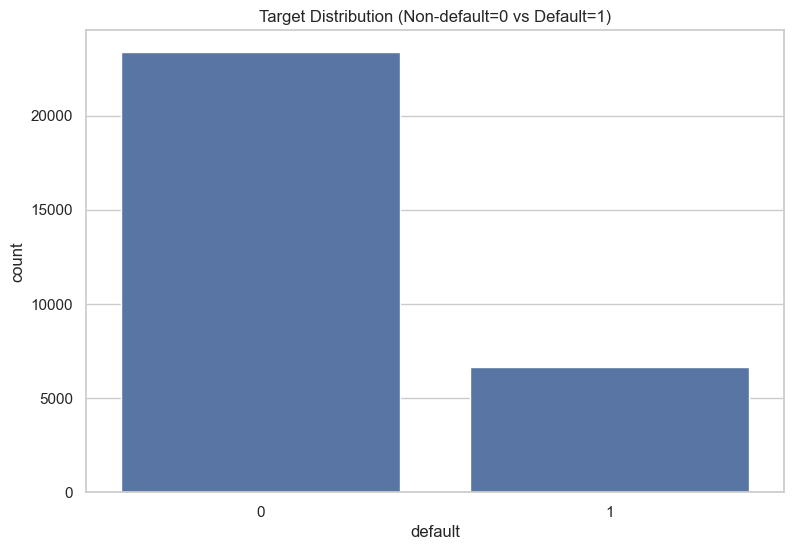

In [14]:
target_counts = df['default'].value_counts().sort_index()
target_pct = df['default'].value_counts(normalize=True).sort_index() * 100
display(pd.DataFrame({'count': target_counts, 'percentage': target_pct.round(2)}))

sns.countplot(x='default', data=df)
plt.title('Target Distribution (Non-default=0 vs Default=1)')
plt.show()


## 4. Categorical value validation
Some categorical codes in the original dataset include undocumented values (e.g., EDUCATION=0,5,6 or MARRIAGE=0). Consolidate them into a single 'Other' code for stability.


In [15]:
# Consolidate undocumented categories
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

display(df[['EDUCATION','MARRIAGE']].apply(pd.Series.value_counts))


,EDUCATION,MARRIAGE
1,10585,13659.0
2,14030,15964.0
3,4917,377.0
4,468,NaN


## 5. Distribution inspection (key numeric features)
Plot distributions for `LIMIT_BAL` and `AGE` to inspect skewness and outliers.


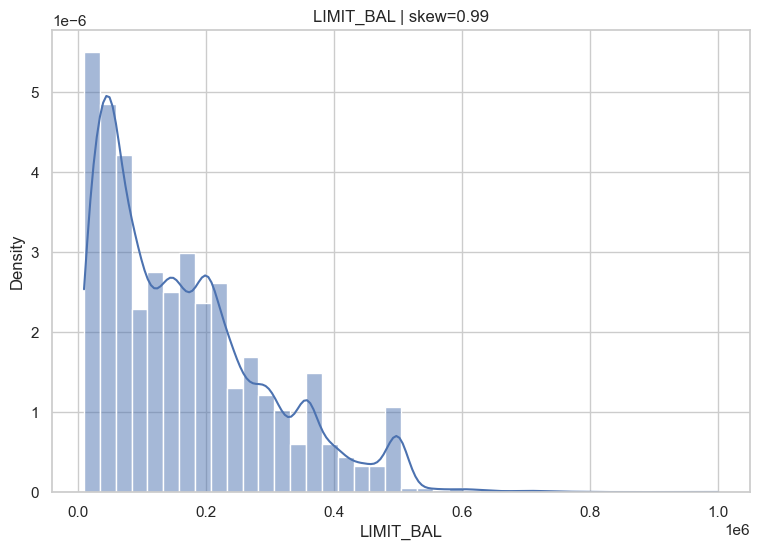

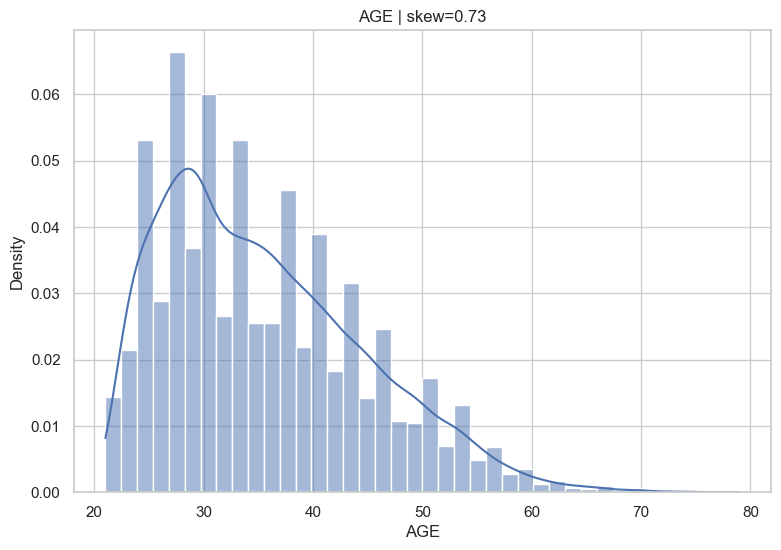

In [16]:
def plot_distribution(col, bins=40):
    sns.histplot(df[col], bins=bins, kde=True, stat='density')
    plt.title(f"{col} | skew={df[col].skew():.2f}")
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.show()

for col in ['LIMIT_BAL','AGE']:
    plot_distribution(col)


## 6. Delinquency features & business-focused engineered variables
Create aggregated features that are interpretable and predictive:
- `num_delayed_payments`: count of months with PAY_*>0
- `ever_late`: binary flag if customer was late in any month
- `total_bill_amt`, `total_pay_amt`
- `payment_ratio` and `credit_utilization`


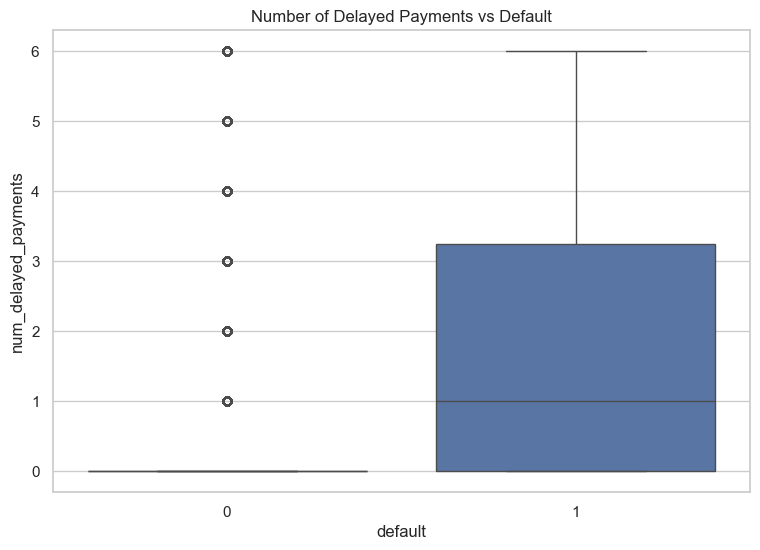

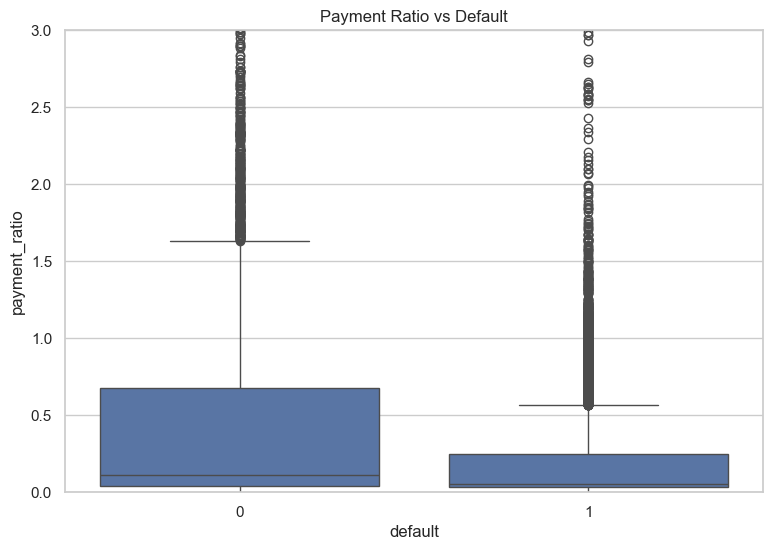

In [17]:
pay_cols = [c for c in df.columns if c.startswith('PAY_') and c not in ('PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6')]
bill_cols = [c for c in df.columns if c.startswith('BILL_AMT')]
pay_amt_cols = [c for c in df.columns if c.startswith('PAY_AMT')]

df['num_delayed_payments'] = (df[pay_cols] > 0).sum(axis=1)
df['ever_late'] = (df[pay_cols] > 0).any(axis=1).astype(int)

df['total_bill_amt'] = df[bill_cols].sum(axis=1)
df['total_pay_amt'] = df[pay_amt_cols].sum(axis=1)

df['payment_ratio'] = df['total_pay_amt'] / (df['total_bill_amt'] + 1)
df['credit_utilization'] = df['total_bill_amt'] / (df['LIMIT_BAL'] + 1)

sns.boxplot(x='default', y='num_delayed_payments', data=df)
plt.title('Number of Delayed Payments vs Default')
plt.show()

sns.boxplot(x='default', y='payment_ratio', data=df)
plt.ylim(0,3)
plt.title('Payment Ratio vs Default')
plt.show()


## 7. Recent behavior features
Recent months are typically more predictive; compute mean of last 3 months for bills/payments.


In [18]:
df['recent_bill_mean'] = df[['BILL_AMT1','BILL_AMT2','BILL_AMT3']].mean(axis=1)
df['recent_pay_mean'] = df[['PAY_AMT1','PAY_AMT2','PAY_AMT3']].mean(axis=1)

display(df[['recent_bill_mean','recent_pay_mean']].describe())


,recent_bill_mean,recent_pay_mean
count,30000.000000,30000.000000
mean,49138.520289,5603.475167
std,69560.379812,13658.079159
min,-47043.000000,0.000000
25%,4475.750000,1208.666667
50%,22310.166667,2347.000000
75%,63862.166667,5469.750000
max,827820.666667,992688.666667


## 8. Correlation analysis (heatmap)
Inspect correlations to find strong linear relationships and potential multicollinearity (helpful for linear models and interpretation).


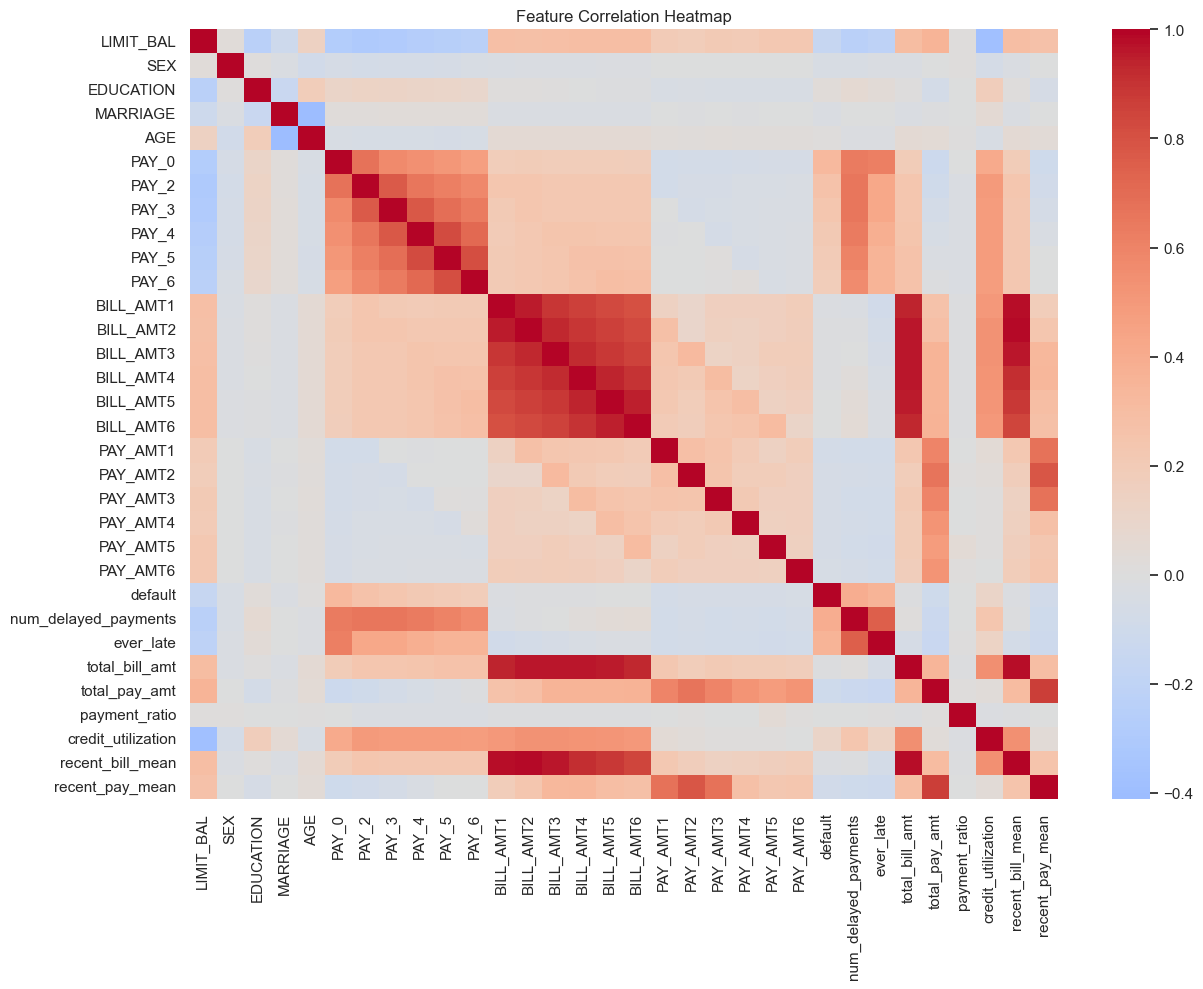

In [19]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()


## 9. Feature relevance estimation
Estimate linear (point-biserial) and non-linear (mutual information) relationships with target.


In [20]:
# Point-biserial correlation
num_features = df.select_dtypes(include=[np.number]).columns.drop('default')
pb = {col: stats.pointbiserialr(df['default'], df[col]).correlation for col in num_features}
pb = pd.Series(pb).sort_values(key=lambda x: x.abs(), ascending=False)
display(pb.head(20))

# Mutual information (needs encoding for categorical variables)
df_mi = df.copy()
for c in df_mi.select_dtypes(include=['object','category']).columns:
    df_mi[c] = LabelEncoder().fit_transform(df_mi[c].astype(str))

mi = pd.Series(
    mutual_info_classif(df_mi.drop(columns=['default']), df_mi['default'], random_state=RND),
    index=df_mi.drop(columns=['default']).columns
).sort_values(ascending=False)
display(mi.head(20))


num_delayed_payments    0.398394
ever_late               0.352858
PAY_0                   0.324794
PAY_2                   0.263551
PAY_3                   0.235253
PAY_4                   0.216614
PAY_5                   0.204149
PAY_6                   0.186866
LIMIT_BAL              -0.153520
credit_utilization      0.115481
total_pay_amt          -0.102354
recent_pay_mean        -0.086592
PAY_AMT1               -0.072929
PAY_AMT2               -0.058579
PAY_AMT4               -0.056827
PAY_AMT3               -0.056250
PAY_AMT5               -0.055124
PAY_AMT6               -0.053183
SEX                    -0.039961
EDUCATION               0.033842
dtype: float64

num_delayed_payments    0.074782
PAY_0                   0.072094
ever_late               0.063626
PAY_2                   0.048487
PAY_3                   0.038640
PAY_5                   0.031352
PAY_4                   0.030734
PAY_6                   0.027939
total_pay_amt           0.024374
PAY_AMT1                0.023977
recent_pay_mean         0.020914
PAY_AMT3                0.017976
credit_utilization      0.016394
PAY_AMT4                0.016143
payment_ratio           0.015978
LIMIT_BAL               0.015759
PAY_AMT2                0.015555
PAY_AMT6                0.011319
BILL_AMT1               0.011136
PAY_AMT5                0.010434
dtype: float64

## 10. Final feature selection for modeling
Build a compact, interpretable feature set suitable for API deployment and model auditing.


In [21]:
selected_features = [
    'LIMIT_BAL', 'total_bill_amt', 'total_pay_amt', 'payment_ratio',
    'credit_utilization', 'num_delayed_payments', 'ever_late',
    'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'recent_bill_mean'
]
final_features = [f for f in selected_features if f in df.columns]
missing_feats = set(selected_features) - set(final_features)
if missing_feats:
    print('Warning: missing features will be excluded:', missing_feats)

final_df = df[final_features].copy()

# Conservative imputation and dtype normalization
num_cols = final_df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = final_df.select_dtypes(include=['object','category']).columns.tolist()

for c in num_cols:
    final_df[c] = final_df[c].fillna(final_df[c].median())
for c in cat_cols:
    if final_df[c].isnull().any():
        final_df[c] = final_df[c].fillna(final_df[c].mode().iloc[0])

for c in ['SEX','EDUCATION','MARRIAGE']:
    if c in final_df.columns:
        final_df[c] = final_df[c].astype('category')

print('final_df shape:', final_df.shape)
display(final_df.head())


final_df shape: (30000, 12)


,LIMIT_BAL,total_bill_amt,total_pay_amt,payment_ratio,credit_utilization,num_delayed_payments,ever_late,AGE,SEX,EDUCATION,MARRIAGE,recent_bill_mean
0,20000.0,7704.0,689.0,0.089422,0.385181,2,1,24,2,2,1,2568.000000
1,120000.0,17077.0,5000.0,0.292774,0.142307,2,1,26,2,2,2,2363.000000
2,90000.0,101653.0,11018.0,0.108387,1.129465,0,0,34,2,2,2,18941.666667
3,50000.0,231334.0,8388.0,0.036259,4.626587,0,0,37,2,2,1,48171.333333
4,50000.0,109339.0,59049.0,0.540049,2.186736,0,0,57,1,2,1,16707.333333


## 11. Train/Test split
Perform a stratified split to preserve class balance between train and test sets.


In [22]:
X = final_df.copy()
y = df['default'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RND
)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (24000, 12) Test: (6000, 12)


## 12. Preprocessing pipelines & Models
Construct numeric and categorical transformers and define three model pipelines: Logistic Regression, Random Forest, LightGBM.


In [23]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['category','object']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', cat_transformer, cat_features)
], remainder='drop')

logreg_pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(solver='saga', max_iter=5000, random_state=RND))])
rf_pipe = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_jobs=-1, random_state=RND))])
lgb_pipe = Pipeline([('pre', preprocessor), ('clf', lgb.LGBMClassifier(random_state=RND, n_jobs=-1))])


## 13. Hyperparameter search setup (RandomizedSearchCV)
Use `roc_auc` as the primary scoring metric. `n_iter` kept moderate for speed in a classroom setting.


In [24]:
param_dist = {
    'logreg': {
        'clf__penalty': ['l2','l1'],
        'clf__C': uniform(loc=0.01, scale=10.0),
        'clf__class_weight': [None, 'balanced']
    },
    'rf': {
        'clf__n_estimators': randint(100, 400),
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': randint(2, 8),
        'clf__max_features': ['sqrt','log2', 0.5, None],
        'clf__class_weight': [None, 'balanced', 'balanced_subsample']
    },
    'lgb': {
        'clf__n_estimators': randint(100, 400),
        'clf__num_leaves': randint(16, 128),
        'clf__learning_rate': uniform(loc=0.01, scale=0.3),
        'clf__max_depth': [-1, 3, 6, 12],
        'clf__subsample': uniform(loc=0.6, scale=0.4)
    }
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RND)
n_iter = 24


In [25]:
def tune_model(pipe, params, X, y, cv, n_iter=24, scoring='roc_auc'):
    rs = RandomizedSearchCV(pipe, params, n_iter=n_iter, cv=cv, scoring=scoring,
                            random_state=RND, n_jobs=-1, verbose=1, return_train_score=False)
    rs.fit(X, y)
    print('Best score (cv):', rs.best_score_)
    print('Best params:', rs.best_params_)
    return rs


### 13.1 Tune and save models
We run a shorter search for classroom speed. In a production or thesis run you may increase `n_iter` and `cv` folds.


In [26]:
print('Tuning Logistic Regression...')
rs_log = tune_model(logreg_pipe, param_dist['logreg'], X_train, y_train, cv=cv, n_iter=20)
best_log = rs_log.best_estimator_
joblib.dump(best_log, 'models/logreg_pipeline.joblib')

print('\nTuning Random Forest...')
rs_rf = tune_model(rf_pipe, param_dist['rf'], X_train, y_train, cv=cv, n_iter=24)
best_rf = rs_rf.best_estimator_
joblib.dump(best_rf, 'models/rf_pipeline.joblib')

print('\nTuning LightGBM...')
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()
param_dist_lgb = param_dist['lgb'].copy()
param_dist_lgb['clf__scale_pos_weight'] = [scale_pos_weight, None]
rs_lgb = tune_model(lgb_pipe, param_dist_lgb, X_train, y_train, cv=cv, n_iter=24)
best_lgb = rs_lgb.best_estimator_
joblib.dump(best_lgb, 'models/lgbm_pipeline.joblib')


Tuning Logistic Regression...
Fitting 4 folds for each of 20 candidates, totalling 80 fits


d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Best score (cv): 0.7556705449079413
Best params: {'clf__C': np.float64(0.21584494295802448), 'clf__class_weight': 'balanced', 'clf__penalty': 'l1'}

Tuning Random Forest...
Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best score (cv): 0.7739836349452525
Best params: {'clf__class_weight': None, 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 108}

Tuning LightGBM...
Fitting 4 folds for each of 24 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639

['models/lgbm_pipeline.joblib']

## 14. Evaluation on hold-out test set
Compute ROC-AUC, PR-AUC, classification report, confusion matrix, and plot ROC & PR curves.


--- LogisticRegression ---
ROC-AUC: 0.7391042611832698
PR-AUC: 0.4919241239733895
              precision    recall  f1-score   support

           0     0.8748    0.7652    0.8163      4673
           1     0.4263    0.6142    0.5032      1327

    accuracy                         0.7318      6000
   macro avg     0.6505    0.6897    0.6598      6000
weighted avg     0.7756    0.7318    0.7471      6000

Confusion matrix:
 [[3576 1097]
 [ 512  815]]
--- RandomForest ---
ROC-AUC: 0.7644954395780987
PR-AUC: 0.5160457925742437
              precision    recall  f1-score   support

           0     0.8290    0.9397    0.8808      4673
           1     0.5989    0.3173    0.4148      1327

    accuracy                         0.8020      6000
   macro avg     0.7139    0.6285    0.6478      6000
weighted avg     0.7781    0.8020    0.7778      6000

Confusion matrix:
 [[4391  282]
 [ 906  421]]
--- LightGBM ---
ROC-AUC: 0.7659280953241786
PR-AUC: 0.5129090130623701
              precision 

d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


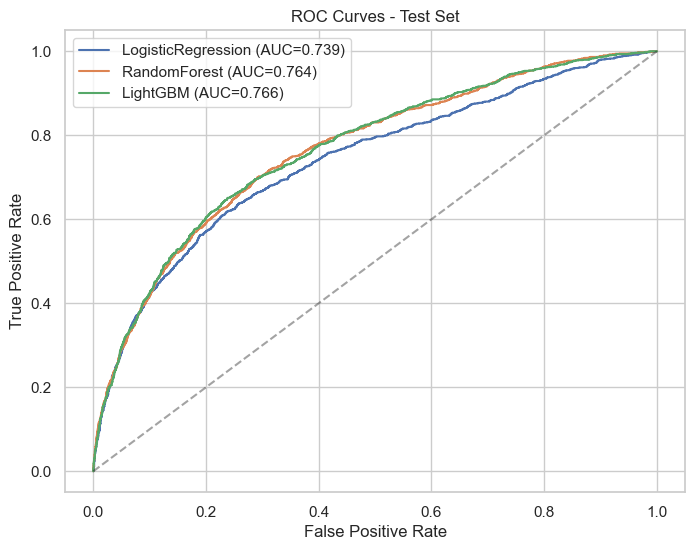

d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


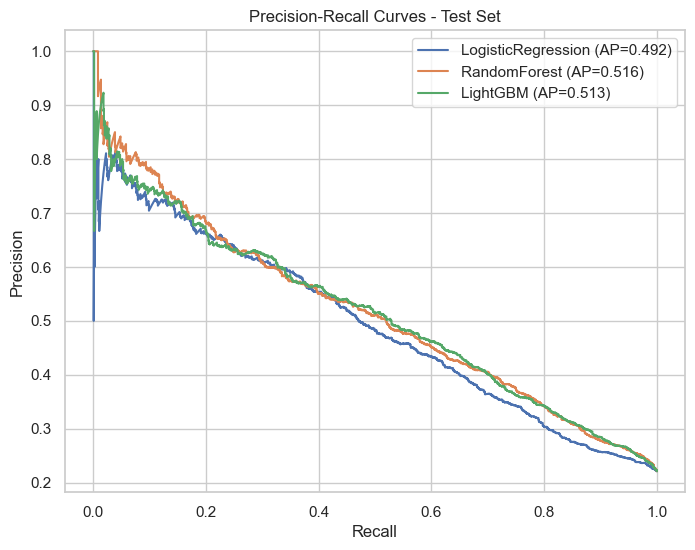

In [27]:
models = {'LogisticRegression': best_log, 'RandomForest': best_rf, 'LightGBM': best_lgb}
results = {}

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    results[name] = {'roc_auc': float(roc), 'pr_auc': float(pr)}
    print(f"--- {name} ---")
    print('ROC-AUC:', roc)
    print('PR-AUC:', pr)
    print(classification_report(y_test, y_pred, digits=4))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.3f})")

plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Test Set')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Test Set')
plt.legend()
plt.show()


d:\Data Science\financial-risk-predictive-analytics\env\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


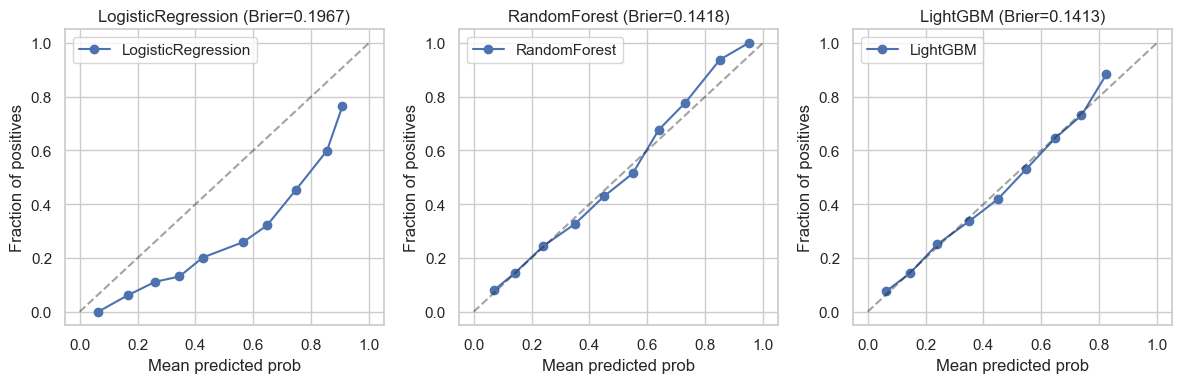

In [28]:
# Calibration plots
from sklearn.calibration import calibration_curve
plt.figure(figsize=(12,4))
for i, (name, model) in enumerate(models.items(), 1):
    y_prob = model.predict_proba(X_test)[:,1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.subplot(1,3,i)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
    plt.plot([0,1],[0,1],'k--', alpha=0.4)
    plt.xlabel('Mean predicted prob')
    plt.ylabel('Fraction of positives')
    plt.title(f"{name} (Brier={brier_score_loss(y_test, y_prob):.4f})")
    plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Save results summary
with open('models/results_summary.json','w') as f:
    json.dump(results, f, indent=2)
print('Saved models and results in ./models/')


Saved models and results in ./models/


## 15. Conclusion

This study demonstrates a complete and principled end-to-end workflow for credit default prediction, covering exploratory data analysis, business-driven feature engineering, model training, and evaluation using appropriate metrics for imbalanced classification.

Tree-based models (Random Forest and LightGBM) consistently outperform logistic regression, achieving ROC–AUC values around **0.75–0.76** and substantially higher Precision–Recall AUC compared to baseline. While these values may appear modest, they are **expected and realistic** given the inherent class imbalance and the limited scope of available features. In credit risk modeling, such performance levels are commonly observed in real-world portfolios, particularly in the absence of external data such as income, employment history, transaction-level behavior, or bureau scores.

Importantly, model evaluation prioritizes **ranking quality and probability calibration** rather than raw accuracy. Calibration curves and Brier scores indicate that the tree-based models produce reasonably well-calibrated probability estimates, which are critical for downstream risk-based decision making.

Overall, the resulting models are **interpretable, calibrated, and suitable as a strong academic baseline**, while clearly identifying avenues for further improvement in applied or production settings.